# Problem Set 2: Networking

Authors:
`Jangwon Park`
`Sascha Frey`
`Kuber Malhotra`

## Key Assumption
* The adjacency matrix is unweighted, undirected, and symmetric

# Import Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import networkx as nx
from sklearn.cluster import KMeans

In [2]:
file_handle = open("SMS-network.txt", 'r')
network_data = file_handle.readlines()

# Sparse matrix of arbitrarily large size
adjacency = sparse.lil_matrix((10000,10000), dtype=np.int8)

# Store the data in an adjacency matrix
for i in range(len(network_data)):
    line = str.split(network_data[i])
    adjacency[int(line[0]), int(line[1])] = 1;
    adjacency[int(line[1]), int(line[0])] = 1; # symmetric, not directional

# Convert to numpy array
adjacency = adjacency.toarray()

# Remove all-zero rows and columns, essentially those left over (10k*10k)
zero_index = np.where(np.sum(adjacency, axis=0) == 0)[0]
adjacency = np.delete(adjacency, zero_index, axis=0)
adjacency = np.delete(adjacency, zero_index, axis=1)

print("Number of nodes in our network: {n:}".format(n=adjacency.shape[0]))
print("Number of edges in our network: {e:}".format(e=int(np.count_nonzero(adjacency)/2)))

Number of nodes in our network: 4039
Number of edges in our network: 88234


# Section I: Exploratory Data Analysis

Text(0.5, 1.05, 'adjacency matrix')

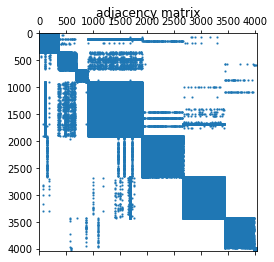

In [3]:
# Visualize our network
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

* Out network is quite sparse.
* The network is approximately "block diagonal".
* We can suspect that our network could be comprised of multiple components which are disconnected from each other.
* There are certain individuals who are connected to others outside their commmunities (blocks) indicated by the streaks. 

### Check connectedness

In [4]:
G = nx.from_numpy_matrix(adjacency) #creates a nx type graphy from a numpy matrix
print("Is our network connected: {a:}".format(a=nx.is_connected(G)))

Is our network connected: True


* Turns out that our network is indeed one giant connected component
* Likely due to the connections established by the streaks (influencers?)

# Node degree distribution

In [5]:
degrees = []
for i,d in enumerate(G.degree):
    degrees.append(d[1])

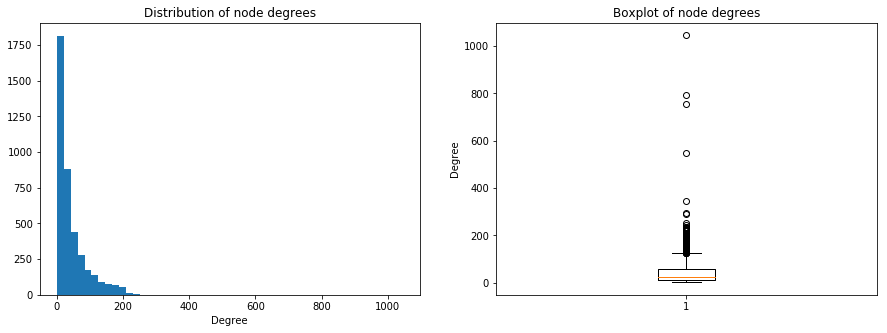

Max. node degree: 1045
Min. node degree: 1
Mean node degree: 43
Median node degree: 25
Nodes with degree greater than 250: [0, 107, 1684, 1888, 1912, 2347, 2543, 3437]


In [6]:
# Distriution of node degrees
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].hist(degrees, bins=50)
ax[0].set_title("Distribution of node degrees")
ax[0].set_xlabel("Degree")

ax[1].boxplot(degrees)
ax[1].set_title("Boxplot of node degrees")
ax[1].set_ylabel("Degree")

plt.show()
degree_thresh=250

influencers_deg = [i for i,v in enumerate(degrees) if v >= degree_thresh]

print("Max. node degree: {m:}".format(m=max(degrees)))
print("Min. node degree: {m:}".format(m=min(degrees)))
print("Mean node degree: {m:}".format(m=int(np.mean(degrees))))
print("Median node degree: {m:}".format(m=int(np.median(degrees))))
print("Nodes with degree greater than {}: {}".format(degree_thresh,influencers_deg))

* Vast majority of the nodes have small degrees
* Node degree is roughly exponentially distributed, with very few nodes have very large degrees, these might be the important nodes

### Betweenness centrality distribution
* A node's betweenness centrality is informally defined as the number of shortest paths that ever pass through a node
* Nodes with high betweenness centralities could potentially be great "information spreaders"

In [9]:
nx.is_bipartite(G)
bw = nx.betweenness_centrality(G)
centralities = bw.values()

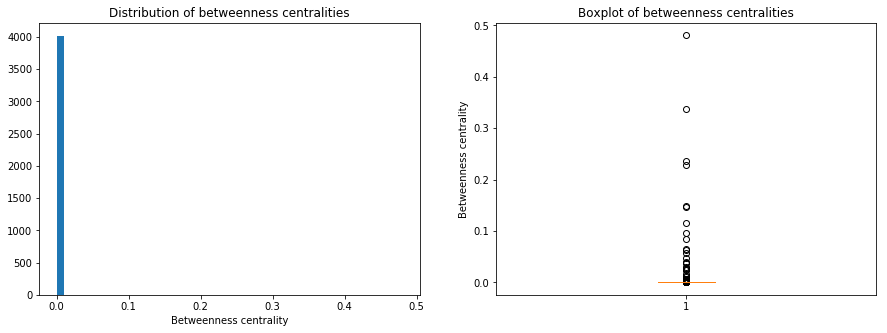

Max. betweenness centrality: 0.48
Min. betweenness centrality: 0.0
Mean betweenness centrality: 0.0006669573568730236


In [10]:
# Distribution of betweenness centralities
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].hist(centralities, bins=50)
ax[0].set_title("Distribution of betweenness centralities")
ax[0].set_xlabel("Betweenness centrality")

ax[1].boxplot(centralities)
ax[1].set_title("Boxplot of betweenness centralities")
ax[1].set_ylabel("Betweenness centrality")

plt.show()


print("Max. betweenness centrality: {m:.2f}".format(m=max(centralities)))
print("Min. betweenness centrality: {m:}".format(m=min(centralities)))
print("Mean betweenness centrality: {m:}".format(m=np.mean(list(centralities))))

* Nearly all nodes have betweenness centrality close to 0 (which we confirm below)
* Very few nodes have anything higher than 0, which implies that there are only a very small set of 'important' individuals
* 

In [11]:
# Count the number of nodes with betweenness centrality > some threshold. Need to think about which is more telling
# depends mostly on resources: how many people should one target?
threshold=[0.1,0.01,0.001]
for threshold in threshold :
    influencers = dict((k, v) for k, v in bw.items() if v >= threshold)
    print("Number of nodes with centrality greater than {thr}: {g:}".format(thr=threshold,g=sum(np.array(list(centralities))>threshold)))
    print("Nodes with centrality greater than {thrs}: {inf}".format(thrs=threshold,inf=influencers.keys()))

Number of nodes with centrality greater than 0.1: 7
Nodes with centrality greater than 0.1: dict_keys([0, 107, 698, 1085, 1684, 1912, 3437])
Number of nodes with centrality greater than 0.01: 24
Nodes with centrality greater than 0.01: dict_keys([0, 58, 107, 136, 171, 348, 414, 428, 483, 563, 567, 594, 686, 698, 860, 862, 1085, 1465, 1577, 1684, 1718, 1912, 3437, 3980])
Number of nodes with centrality greater than 0.001: 96
Nodes with centrality greater than 0.001: dict_keys([0, 34, 56, 58, 107, 119, 136, 171, 173, 198, 348, 353, 363, 366, 376, 389, 414, 428, 475, 483, 484, 517, 526, 538, 563, 566, 567, 580, 594, 596, 637, 651, 686, 697, 698, 703, 713, 719, 745, 747, 800, 803, 805, 810, 819, 823, 828, 830, 860, 862, 990, 1085, 1165, 1171, 1352, 1361, 1405, 1419, 1420, 1465, 1505, 1534, 1577, 1642, 1656, 1663, 1666, 1684, 1718, 1758, 1912, 1941, 2007, 2047, 2133, 2189, 2266, 2289, 2347, 2468, 2542, 2543, 3437, 3456, 3495, 3561, 3633, 3677, 3684, 3756, 3830, 3851, 3877, 3948, 3980, 4031]

### Closeness centrality distribution

* A node's closeness centrality is informally defined as the reciprocal of the sum of all its pairwise shortest path lengths to the rest of the network
* Nodes with closeness centrality close to 1 can therefore be considered 'important' for spreading news.

In [12]:
closeness = nx.closeness_centrality(G)
close = closeness.values()

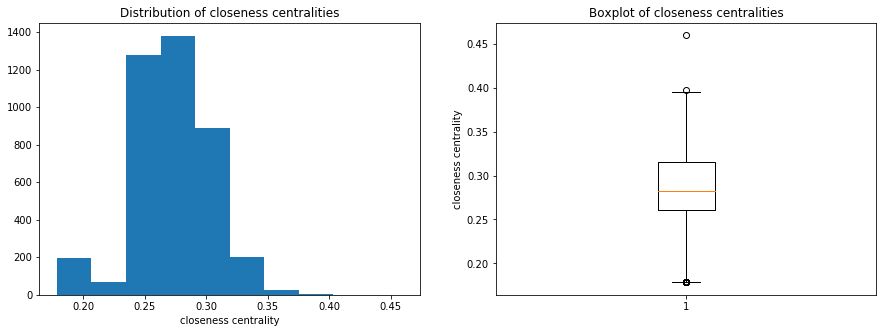

Max. closeness centrality: 0.46
Min. closeness centrality: 0.1782545358230698
Mean closeness centrality: 0.2761677635668376


In [13]:
# Distribution of closeness centralities
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].hist(close)
ax[0].set_title("Distribution of closeness centralities")
ax[0].set_xlabel("closeness centrality")

ax[1].boxplot(close)
ax[1].set_title("Boxplot of closeness centralities")
ax[1].set_ylabel("closeness centrality")

plt.show()

print("Max. closeness centrality: {m:.2f}".format(m=max(close)))
print("Min. closeness centrality: {m:}".format(m=min(close)))
print("Mean closeness centrality: {m:}".format(m=np.mean(list(close))))

* Closeness centrality appears more normally distributed about the mean 0.276, which may imply that this is a more informative feature than betweenness centrality
* Could also imply that all of them are close but connected only through a few people (bridges in a sense)

### Eigenvector Centrality

In [14]:
eig=nx.eigenvector_centrality(G)

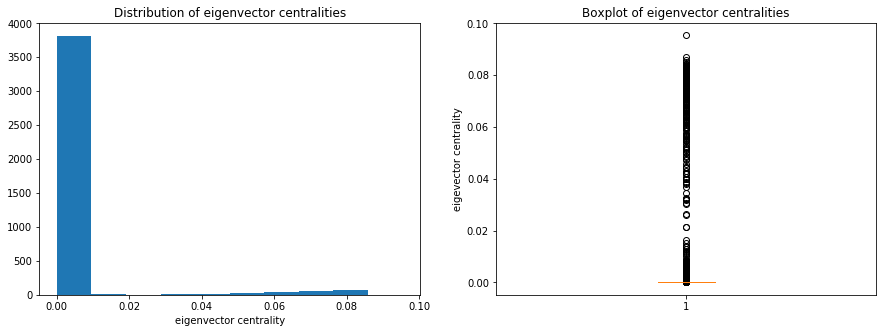

In [15]:
eigenvect=eig.values()
# Distribution of eigenvector centralities
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].hist(eigenvect)
ax[0].set_title("Distribution of eigenvector centralities")
ax[0].set_xlabel("eigenvector centrality")

ax[1].boxplot(eigenvect)
ax[1].set_title("Boxplot of eigenvector centralities")
ax[1].set_ylabel("eigevector centrality")

plt.show()

In [16]:
threshold=[0.08]
for threshold in threshold :
    inf_eig = dict((k, v) for k, v in eig.items() if v >= threshold)
    print("Number of nodes with eigenvector centrality greater than {thr}: {g:}".format(thr=threshold,g=sum(np.array(list(eigenvect))>threshold)))
    print("Nodes with eigenvector centrality greater than {thrs}: {inf}".format(thrs=threshold,inf=inf_eig.keys()))

Number of nodes with eigenvector centrality greater than 0.08: 43
Nodes with eigenvector centrality greater than 0.08: dict_keys([1912, 1938, 1943, 1946, 1983, 1985, 1993, 2059, 2073, 2078, 2088, 2090, 2118, 2123, 2131, 2142, 2150, 2188, 2201, 2206, 2218, 2220, 2229, 2233, 2240, 2244, 2266, 2309, 2324, 2340, 2347, 2369, 2410, 2464, 2507, 2560, 2586, 2590, 2601, 2602, 2604, 2607, 2611])


* Issue with this measure is that when a node is connected to well-connected nodes then the value is high. Looking at the adjacency matrix, it essentially shows those nodes in the largest box, as they are all very well interconnected but only within their own community. 
* In the clustering section we will look at segmenting those "communities" 

### Correlation between betweenness/closeness/degree centralities

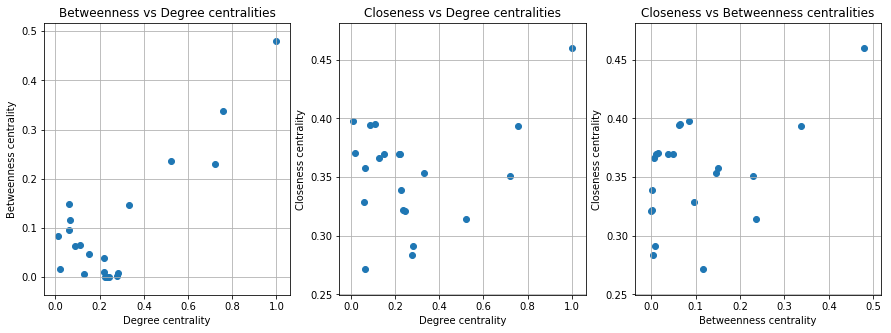

In [17]:
# First normalize degrees to be in [0,1]
degrees = np.array(degrees) / max(degrees)

#choose only top ones to plot
number=10
index=list(set(list(np.argsort(degrees)[-number:])+list(np.argsort(list(close))[-number:])+list(np.argsort(list(centralities))[-number:])))

cls = [list(close)[i] for i in index]
deg = [degrees[i] for i in index]
bwcent= [list(centralities)[i] for i in index]

# Plot correlation
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].scatter(deg, bwcent)
ax[0].set_title("Betweenness vs Degree centralities")
ax[0].set_ylabel("Betweenness centrality")
ax[0].set_xlabel("Degree centrality")

ax[1].scatter(deg, cls)
ax[1].set_title("Closeness vs Degree centralities")
ax[1].set_ylabel("Closeness centrality")
ax[1].set_xlabel("Degree centrality")

ax[2].scatter(bwcent, cls)
ax[2].set_title("Closeness vs Betweenness centralities")
ax[2].set_ylabel("Closeness centrality")
ax[2].set_xlabel("Betweenness centrality")

ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

In [18]:
print("High Impact Nodes ({} biggest): {}".format(number,index))

High Impact Nodes (10 biggest): [0, 1800, 1684, 1912, 414, 2347, 171, 428, 563, 567, 58, 698, 1085, 348, 1888, 483, 107, 3437, 2543, 376, 1663]


* There appears to be some positive, linear relationship among all three metrics.
* Correlation analysis involving betweenness centrality is limited because so many values are so close to 0.
* Nevertheless, this implies that a node with high degree centrality, for instance, may have high betweenness and closeness centralities.
* For the top nodes in each of the measures there is a definite correlation, afterwards it drops.
* The variable Index, are the influencers in terms of having maximum closeness and/or degree and/or betweenness

### Shortest path lengths (min, max, and mean)

In [19]:
lengths = nx.shortest_path_length(G) # variable type: generator
mean_lengths = []
max_lengths = []
min_lengths = []
for n,d in lengths:
    max_lengths.append(max(d.values()))
    min_lengths.append(min(list(d.values())[1:])) # not including itself => o/w it will return min = 0
    mean_lengths.append(np.mean(list((d.values()))))

Text(0, 0.5, 'Length')

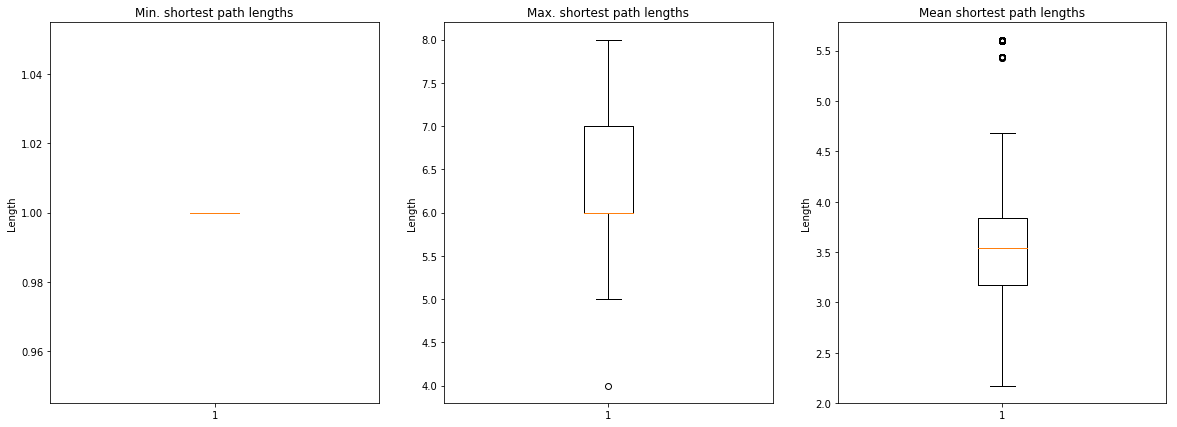

In [20]:
# Box plot of pairwise shortest path lengths
fig, ax = plt.subplots(1,3)
fig.set_figheight(7)
fig.set_figwidth(20)

ax[0].boxplot(min_lengths[min_lengths!=0])
ax[0].set_title("Min. shortest path lengths")
ax[0].set_ylabel("Length")

ax[1].boxplot(max_lengths)
ax[1].set_title("Max. shortest path lengths")
ax[1].set_ylabel("Length")

ax[2].boxplot(mean_lengths)
ax[2].set_title("Mean shortest path lengths")
ax[2].set_ylabel("Length")

* Despite a large network, max. shortest path ever is only 8 hops.
* Mean shortest path length (for each node) is roughly equally distributed about 3.5 hops; however, there are a very few nodes with slightly more than that.
* 'Small world phenomenon': On average, I could reach a total stranger who could be on the other side of the world through only 3.5 people.

# Section II: Clustering
Some assumptions on how to quantify the 'importance' of nodes:
* Having a high betweenness centrality is equivalent to spreading information fast (since more shortest paths pass through these nodes)
* Having a high closeness centrality is equivalent to spreading information fast (since paths through these nodes are shorter)
* Having a high degree centrality is equivalent to spreading information fast (since there are more neighbors)

### Feature generation

In [21]:
# Convert to iterable data types (e.g. list)
degrees = list(degrees)
centralities = list(centralities)
close = list(close)

# Create a vector of length 3 for each node: [degree centrality, betweenness centrality, closeness centrality]
X = np.empty((adjacency.shape[0], 3))
for i in range(adjacency.shape[0]):
    X[i,0] = degrees[i]
    X[i,1] = centralities[i]
    X[i,2] = close[i]

### K-means clustering with data matrix X (with different values of K)

In [22]:
# candidate values of K
k = [3, 4, 5, 6, 7, 8, 9, 10]

# Fit KMeans model
models = []
y_kmeans = []
for i, c in enumerate(k):
    kmeans = KMeans(n_clusters = c)
    kmeans.fit(X)
    models.append(kmeans)
    y_kmeans.append(kmeans.predict(X))

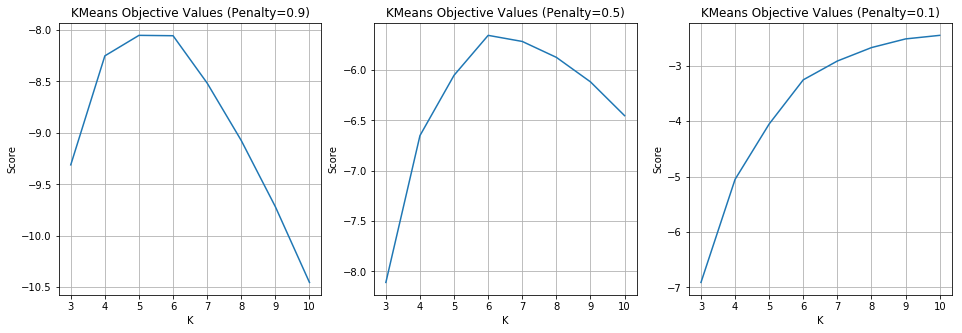

In [23]:
# Visualize the objective values for each value of K
scores1 = []
scores2 = []
scores3 = []
for i, s in enumerate(models):
    scores1.append(s.score(X) - 0.9*k[i])
    scores2.append(s.score(X) - 0.5*k[i])
    scores3.append(s.score(X) - 0.1*k[i])

fig, ax = plt.subplots(1,3)
fig.set_figwidth(16)
fig.set_figheight(5)

ax[0].plot(k,scores1)
ax[0].set_title("KMeans Objective Values (Penalty=0.9)")
ax[0].set_xlabel("K")
ax[0].set_ylabel("Score")
ax[0].grid()

ax[1].plot(k,scores2)
ax[1].set_title("KMeans Objective Values (Penalty=0.5)")
ax[1].set_xlabel("K")
ax[1].set_ylabel("Score")
ax[1].grid()

ax[2].plot(k,scores3)
ax[2].set_title("KMeans Objective Values (Penalty=0.1)")
ax[2].set_xlabel("K")
ax[2].set_ylabel("Score")
ax[2].grid()

plt.show()

* We apply some penalty for including higher K
* For different sizes of this penalty, we can see that `K = 6` is roughly a reasonable choice

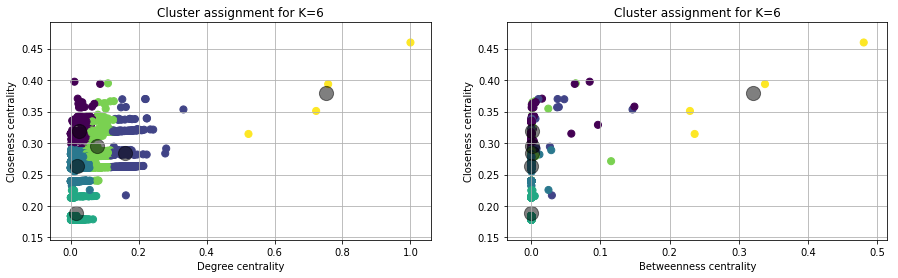

In [24]:
# Visualize
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

ax[0].scatter(X[:, 0], X[:, 2], c=y_kmeans[3], s=50, cmap='viridis')
centers = models[3].cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
ax[0].set_title("Cluster assignment for K=6")
ax[0].set_ylabel("Closeness centrality")
ax[0].set_xlabel("Degree centrality")
ax[0].grid()

ax[1].scatter(X[:, 1], X[:, 2], c=y_kmeans[3], s=50, cmap='viridis')
centers = models[3].cluster_centers_
ax[1].scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5);
ax[1].set_title("Cluster assignment for K=6")
ax[1].set_ylabel("Closeness centrality")
ax[1].set_xlabel("Betweenness centrality")
ax[1].grid()

In [25]:
# Find the nodes in the "yellow" cluster
nodes = np.where(models[3].labels_ == 5)[0]
print("Nodes in the 'most important' cluster: {n:}".format(n=nodes))

Nodes in the 'most important' cluster: [ 107 1684 1912 3437]


* According to K-means with K=6, these four individuals are best for spreading news quickly

### Result visualization

In [26]:
import pygsp as pg
from matplotlib import gridspec

# Create pygsp graph for visualization
G_flow = pg.graphs.Graph(adjacency)
G_flow.set_coordinates('spring')

Plot the graph

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[]

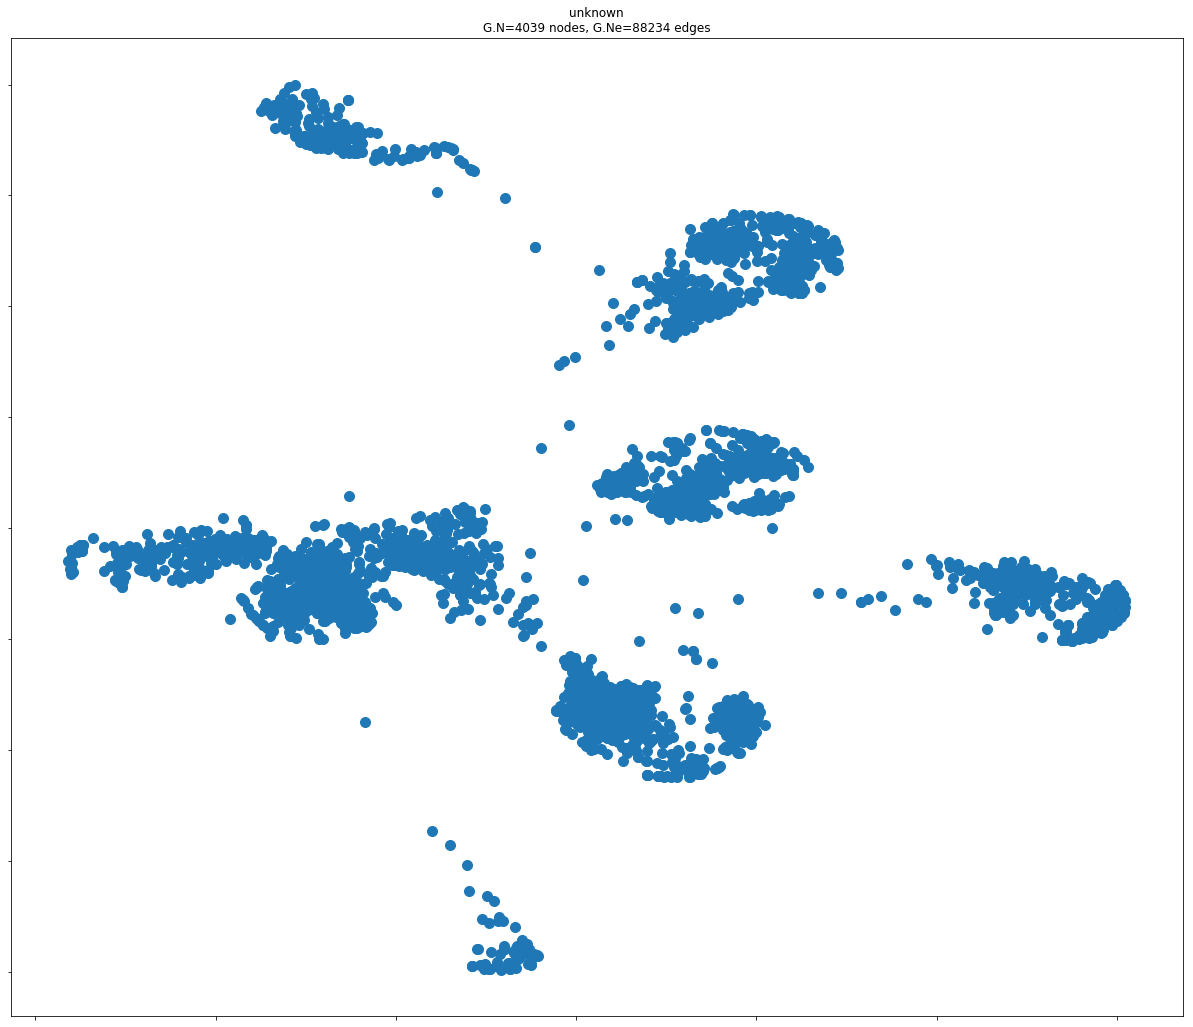

In [27]:
plt.figure(figsize=(21, 18))
ax = plt.gca()
pg.plotting.plot_graph(G_flow, ax=ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

We look for communities in the graph.

In [28]:
c=list(nx.algorithms.community.greedy_modularity_communities(G))

In [29]:
print("{} communities found".format(len(c)))

13 communities found


In [30]:
node_community = []
# For each node we look for the corresponding community
for n in range(G_flow.N):
    aux = -1
    for i, c_i in enumerate(c):
        if n in c_i:
            aux = i
            break
    node_community.append(aux)

node_community = np.array(node_community)

We plot the graph with communities in different colors and the four 'most important' nodes that we found above.

[]

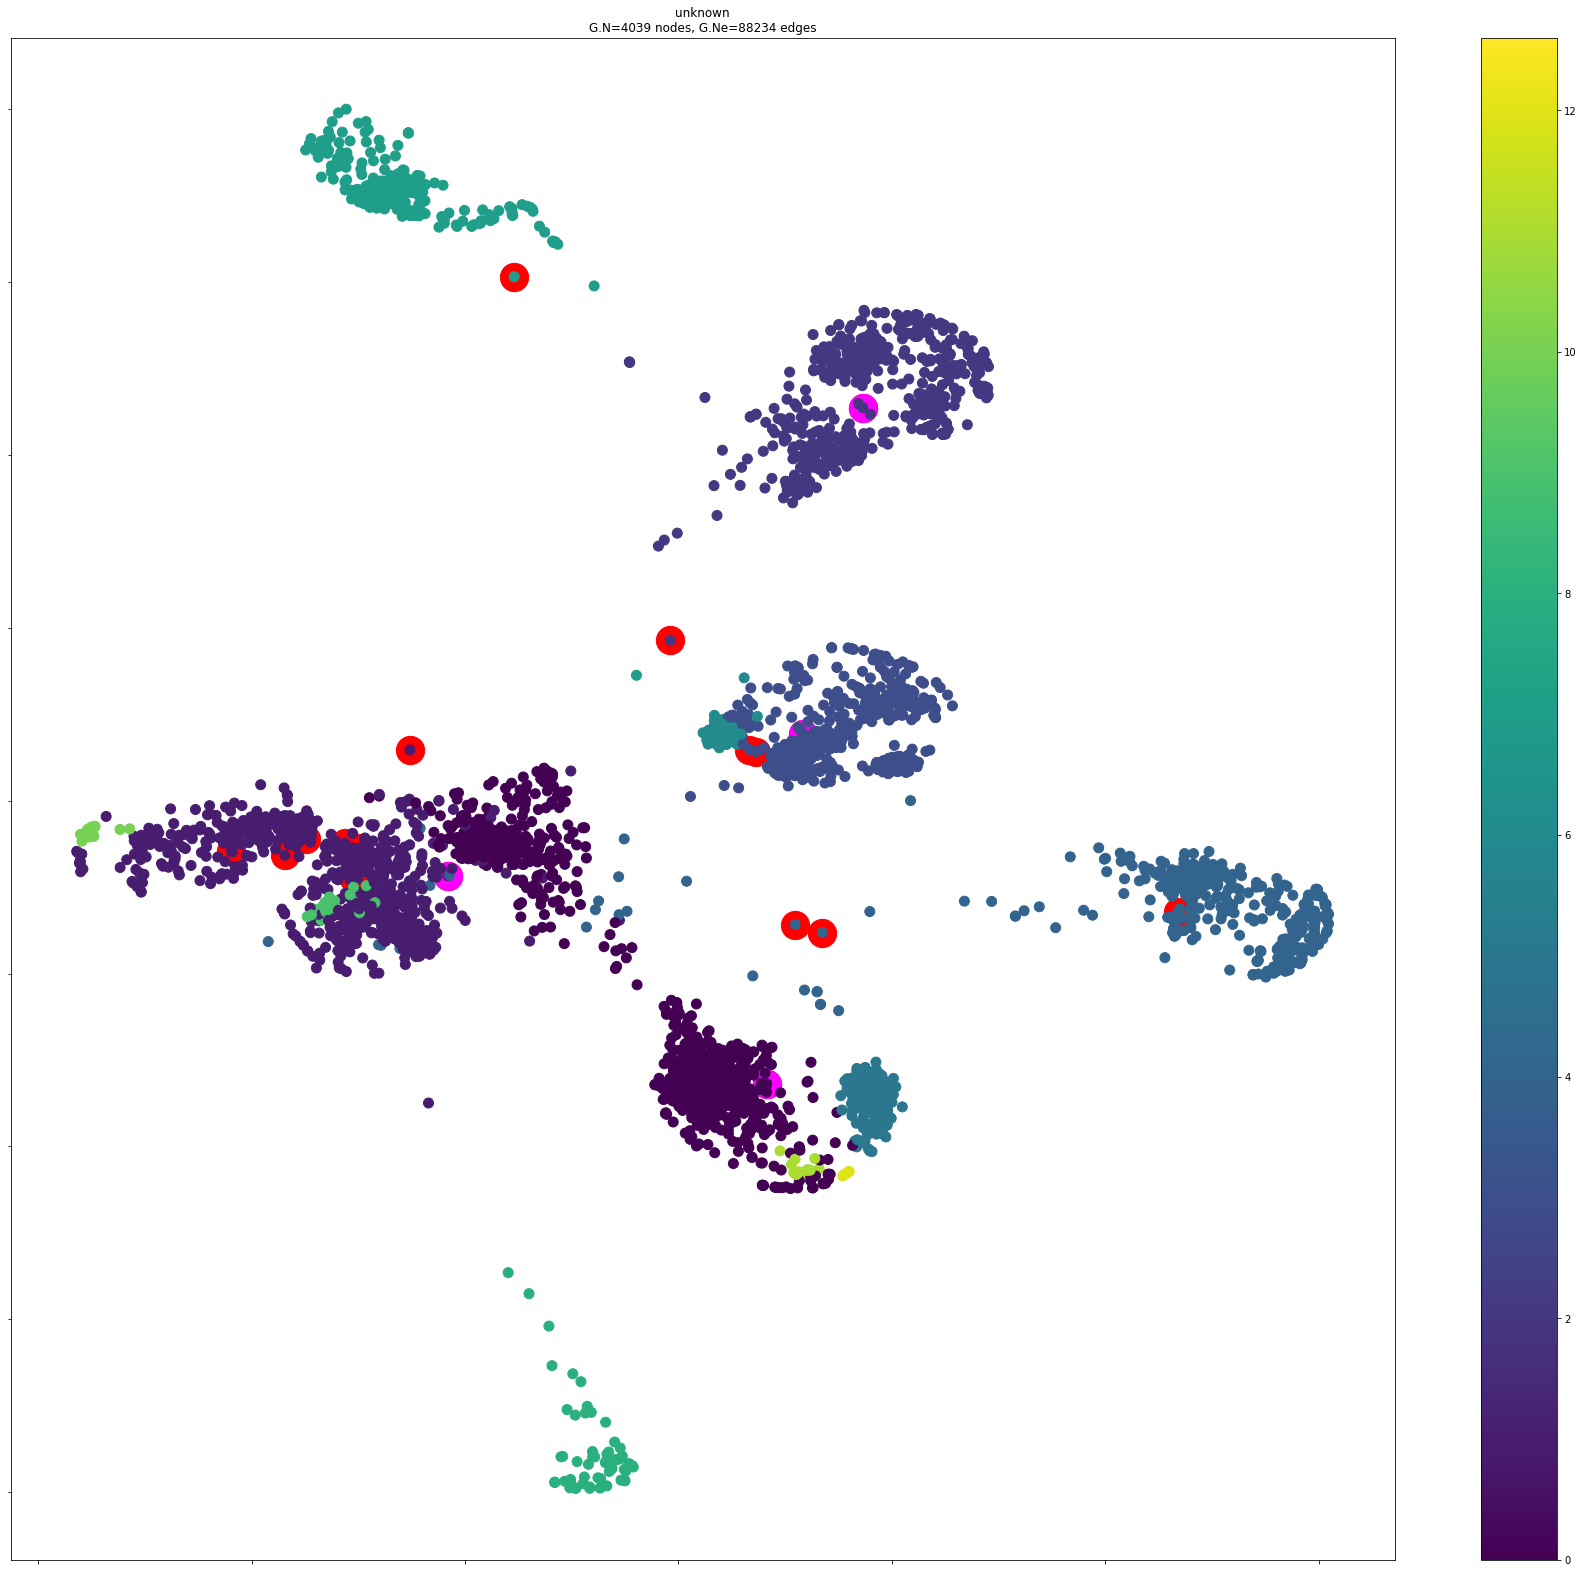

In [36]:
important_nodes = [107, 1684, 1912, 3437]

plt.figure(figsize=(31, 28))
ax = plt.gca()
pg.plotting.plot_signal(G_flow, signal=node_community, ax=ax)

# Plot the important nodes in a different color
coords = G_flow.coords[index]
ax.scatter(coords[:, 0], coords[:, 1], color='r', s=800)
coords_2 = G_flow.coords[important_nodes]
ax.scatter(coords_2[:, 0], coords_2[:, 1], color='magenta', s=800)

ax.set_yticklabels([])
ax.set_xticklabels([])